In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from PIL import Image

plt.ion() 

In [2]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [3]:
# data_dir = 'data/hymenoptera_data'
data_dir ='/home/sangeeta/Desktop/phd/sem/10th sem/Image_processing/assignment1/ques2/assignment1_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train','test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

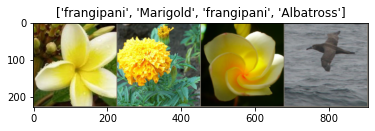

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [5]:

def train_model(model, criterion, optimizer, scheduler, num_epochs=25,fig_title='convnet'):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(0,num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
#                 if phase == 'test':
#                     print(labels.data,preds)
            
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            if phase == 'test':
                test_losses.append(epoch_loss)
                 
                test_acc.append(epoch_acc)
            else:
                train_losses.append(epoch_loss)
                 
                train_acc.append(epoch_acc)
                
                

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())


    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    plot_loss_acc(train_losses,train_acc,'Training loss and accuracy', fig_title+'_train')
    plot_loss_acc(test_losses,test_acc,'Testing loss and accuracy', fig_title+'_test')
    return model

In [6]:
def plot_loss_acc(loss,acc,label, title):
    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('Loss', color=color)
    ax1.plot(range(0,len(loss)), loss, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel('Accuracy', color=color)  # we already handled the x-label with ax1
    ax2.plot(range(0,len(loss)), acc, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.title(label)
    plt.savefig(title+'.png')
    plt.show()
    
    return

In [7]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

### ConvNet as fixed feature extractor

In [8]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 6)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)


Epoch 0/24
----------
train Loss: 1.3017 Acc: 0.4833
test Loss: 0.2936 Acc: 0.9167
Epoch 1/24
----------
train Loss: 0.5079 Acc: 0.8708
test Loss: 0.0593 Acc: 1.0000
Epoch 2/24
----------
train Loss: 0.5243 Acc: 0.8167
test Loss: 0.0505 Acc: 0.9917
Epoch 3/24
----------
train Loss: 0.4212 Acc: 0.8583
test Loss: 0.0299 Acc: 0.9917
Epoch 4/24
----------
train Loss: 0.3572 Acc: 0.8917
test Loss: 0.0501 Acc: 0.9833
Epoch 5/24
----------
train Loss: 0.3866 Acc: 0.8750
test Loss: 0.0490 Acc: 0.9917
Epoch 6/24
----------
train Loss: 0.5219 Acc: 0.8250
test Loss: 0.0209 Acc: 0.9917
Epoch 7/24
----------
train Loss: 0.3800 Acc: 0.8875
test Loss: 0.0327 Acc: 0.9917
Epoch 8/24
----------
train Loss: 0.2272 Acc: 0.9375
test Loss: 0.0119 Acc: 1.0000
Epoch 9/24
----------
train Loss: 0.1949 Acc: 0.9542
test Loss: 0.0190 Acc: 0.9917
Epoch 10/24
----------
train Loss: 0.2663 Acc: 0.9208
test Loss: 0.0297 Acc: 0.9833
Epoch 11/24
----------
train Loss: 0.3030 Acc: 0.8917
test Loss: 0.0258 Acc: 0.9917
Ep

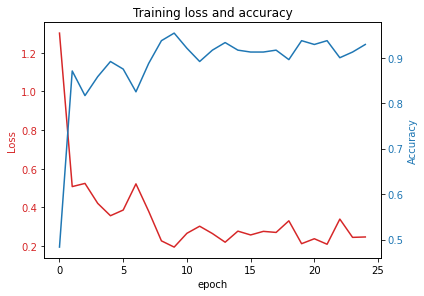

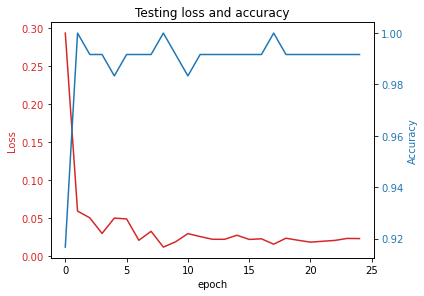

In [10]:
train_losses, test_losses, train_acc, test_acc = [],[],[],[]
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25,fig_title='fixed_convnet')

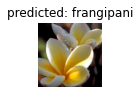

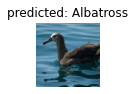

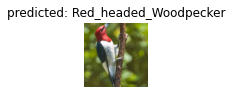

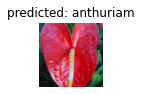

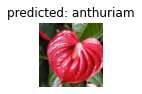

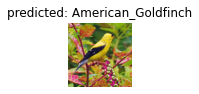

In [11]:
visualize_model(model_conv)

plt.ioff()
plt.show()

### Fine tuning the classifier

In [12]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 6.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 6)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Epoch 0/24
----------
train Loss: 1.0331 Acc: 0.6042
test Loss: 0.0452 Acc: 0.9917
Epoch 1/24
----------
train Loss: 0.3989 Acc: 0.8833
test Loss: 0.0059 Acc: 1.0000
Epoch 2/24
----------
train Loss: 0.2784 Acc: 0.9125
test Loss: 0.0083 Acc: 1.0000
Epoch 3/24
----------
train Loss: 0.3233 Acc: 0.9042
test Loss: 0.0076 Acc: 1.0000
Epoch 4/24
----------
train Loss: 0.3793 Acc: 0.8667
test Loss: 0.0033 Acc: 1.0000
Epoch 5/24
----------
train Loss: 0.2796 Acc: 0.9208
test Loss: 0.0029 Acc: 1.0000
Epoch 6/24
----------
train Loss: 0.2111 Acc: 0.9417
test Loss: 0.0045 Acc: 1.0000
Epoch 7/24
----------
train Loss: 0.2079 Acc: 0.9292
test Loss: 0.0037 Acc: 1.0000
Epoch 8/24
----------
train Loss: 0.1709 Acc: 0.9250
test Loss: 0.0058 Acc: 1.0000
Epoch 9/24
----------
train Loss: 0.2193 Acc: 0.9417
test Loss: 0.0045 Acc: 1.0000
Epoch 10/24
----------
train Loss: 0.1496 Acc: 0.9458
test Loss: 0.0086 Acc: 0.9917
Epoch 11/24
----------
train Loss: 0.1517 Acc: 0.9583
test Loss: 0.0019 Acc: 1.0000
Ep

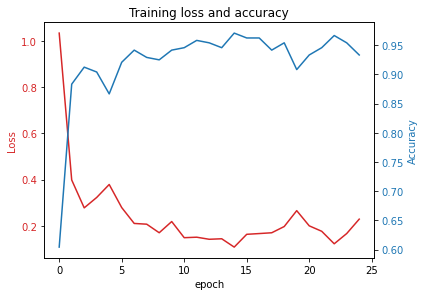

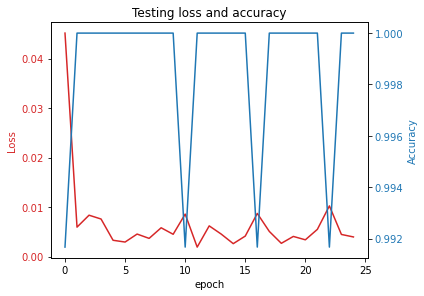

In [13]:
train_losses, test_losses, train_acc, test_acc = [],[],[],[]
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25,fig_title='finetune')

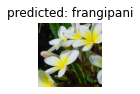

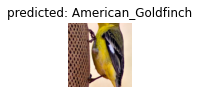

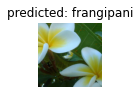

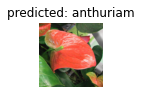

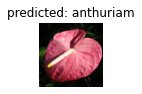

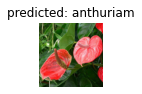

In [14]:
visualize_model(model_ft)